# Table of Contents
```
1. Business Understanding
   1.1. Problem Description
2. Data Understanding
   2.1. Import Libraries, Modules, Functions, Objects, etc.
   2.2. User Defined Functions (UDFs)
   2.3. Data Loading
   2.4. Exploratory Data Analysis (EDA)
        2.4.1. Text EDA: Understand the raw data with Descriptive Statistics
        2.4.2. Visual EDA: Understand the data with Visualizations
               2.4.2.1. Draw Univariate plots to better understand each attribute
               2.4.2.2. Draw Multivariate plots to better understand the relationship between attributes
3. Research
   3.1. List of selected algorithms to build models
   3.2. List of model evaluation metrics
4. Data Preprocessing
   4.1. Data Cleaning
   4.2. Feature Selection
   4.3. Feature Engineering
   4.4. Dimensionality Reduction
   4.5. Split datasets for train-test
   4.6. Data Transforms
        4.6.1. Transforming Numerical type
        4.6.2. Transforming Categorical type
5. Model Development
6. Model Refinement
7. Final Model Selection
8. Conclusion
```

# 1. Business Understanding

## 1.1. Problem Description

**`Problem statement`**:

`In business terms`: 

A business owning a supermarket mall and through its membership cards, has collected some basic data about its customers such as Customer ID, Age, Gender, Annual Income, and Spending score. Spending score is number (value ranges from 1 to 100) that the business assigns to its customer based on its defined parameters such as customer behavior and spending pattern. 

The business wants to identify who are the target customers with whom the marketing team can start a marketing strategy (easy to converse).

`In analytical terms`: 

Using a clustering algorithm, identify different customer segments (clusters) and recommend one or more clusters to the business as the `Target segment(s)/ cluster(s)` for it to plan a marketing strategy and to improve its overall revenue. The customer data are available in the filename `Mall_Customers.csv`.

**`Type of the problem`**: Unsupervised Learning - Clustering

**`Data source(s)`**: [Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)
    
**`Author(s)`**: Balasubramanian Chandran

# 2. Data Understanding

## 2.1. Import Libraries, Modules, Functions, Objects, etc.

In [1]:
# Import necessary libraries for this project
import sys         as sys
import numpy       as np
import pandas      as pd
import scipy       as sp
import seaborn     as sns
import matplotlib  as mpl
import pickle      as pickle
import warnings

# Import necessary Modules, Functions and Objects from the Libraries
from pandas                        import read_csv, crosstab
from collections                   import Counter
from scipy.stats                   import pearsonr
from sklearn.metrics               import silhouette_score, davies_bouldin_score
from sklearn.preprocessing         import StandardScaler
from sklearn.cluster               import KMeans
from mpl_toolkits.mplot3d          import Axes3D
from matplotlib                    import pyplot as plt

# Check the versions of the imported libraries
print("Versions of imported libraries:")
print("Python:     {}".format(sys.version))
print("Numpy:      {}".format(np.__version__))
print("Pandas:     {}".format(pd.__version__))
print("SciPy:      {}".format(sp.__version__))
print("Seaborn:    {}".format(sns.__version__))
print("Matplotlib: {}".format(mpl.__version__))

# Optional settings
mpl.style.use('ggplot')
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None, 'precision', 3)
warnings.filterwarnings('ignore')

print(__doc__)

Versions of imported libraries:
Python:     3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Numpy:      1.19.5
Pandas:     1.3.2
SciPy:      1.6.2
Seaborn:    0.11.2
Matplotlib: 3.4.2
Automatically created module for IPython interactive environment


## 2.2. User Defined Functions (UDFs)

In [2]:
def plot_histograms(df, features, rows, cols):
    fig = plt.figure(figsize=(15,4))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows,cols,i+1)
        df[feature].hist(bins=20, ax=ax, facecolor='midnightblue')
        ax.set_title("Distribution of "+feature, color='brown', size='large')
    #ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()

In [3]:
def plot_genderdistribution(df, features, title, rows, cols):
    fig = plt.figure(figsize=(14, 4))
    for i, f in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        sns.kdeplot(data=df, x=f, hue='Gender', bw_adjust=0.8, color='viridis')
        plt.title(title+' by '+f, size='large', alpha=0.6)
    fig.tight_layout()
    plt.show()

In [4]:
def plot_barchart(df, x, y, hue):
    plt.figure(figsize=(20, 4))
    sns.barplot(data=df, x=x, y=y, hue=hue, ci=0, saturation=0.6)
    plt.title(x+' distibution by '+y, size='x-large', alpha=0.6)

In [5]:
def plot_correlationmap(df):
    plt.figure(figsize = (5, 5))
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center='light', as_cmap=True)
    sns.heatmap(corr, mask=mask, center=0, annot=True, fmt='0.03f', square=True, cmap=cmap)
    plt.show()

In [6]:
def plot_scatterchart(df, x, y, rows, cols):
    fig = plt.figure(figsize=(12, 5))
    for i, f in enumerate(x):
        title = x[i] + ' vs ' + y
        ax = fig.add_subplot(rows, cols, i+1)
        sns.scatterplot(data=df, x=df[f], y=df[y], hue=df.Gender, s=40, palette='deep')
        ax.set_xlabel(f, fontsize=13, alpha=0.8)
        ax.set_ylabel(y, fontsize=13, alpha=0.8)
        ax.set_title(title, fontsize=15, alpha=0.8)
    fig.tight_layout()
    plt.show()    


In [7]:
def standardize(df, f):
    ss  = StandardScaler()
    dfs = ss.fit_transform(df[f].values.reshape(-1, 1))
    return dfs

In [8]:
def plot_regression(df, x, y, scale):
    ageM    = df[df['Gender'] == 'Male'][x]
    ageF    = df[df['Gender'] == 'Female'][x]
    incomeM = df[df['Gender'] == 'Male'][y]
    incomeF = df[df['Gender'] == 'Female'][y]
    rM, _   = pearsonr(ageM.values, incomeM.values)
    rF, _   = pearsonr(ageF.values, incomeF.values)
    title   = x + ' vs ' + y + ' - ' + scale
    sns.lmplot(data=df, x=x, y=y, hue='Gender', aspect=1.5)
    plt.title(title, fontsize=15, alpha=0.8)
    plt.xlabel(x, fontsize=13, alpha=.8)
    plt.ylabel(y, fontsize=13, alpha=0.8)
    xpos  = (df[x].values).max()
    ypos1 = (df[y].values).max() - ((df[y].values).max() * 0.05)
    if scale == 'Unscaled':
        ypos2 = (df[y].values).max() - ((df[y].values).max() * 0.10)
    else:
        ypos2 = (df[y].values).max() - ((df[y].values).max() * 0.15)
    plt.text(xpos, ypos1, 'Pearson Coeff (r): {:.2f}'.format(rM), c='darkblue')
    plt.text(xpos, ypos2, 'Pearson Coeff (r): {:.2f}'.format(rF), c='brown')
    plt.tight_layout
    plt.show()


In [9]:
def plot_performance_metrics(scores_list, score_names, colors, clusters):
    fig, axes = plt.subplots(1, len(score_names), figsize=(14, 5))
    for i in range(len(score_names)):
        axes[i].bar(clusters, scores_list[i], color=colors[i])
        axes[i].set_title(score_names[i], fontsize=15, alpha=0.6, pad=20)
    j = 0
    for scores in scores_list:
        xpos = 2
        for i in scores:
            text = str(i)[:5]
            axes[j].text(x=xpos, y=i, s=text, ha='center', va='bottom')
            for spine in axes[j].spines:
                axes[j].spines[spine].set_visible(False)
                axes[j].spines['left'].set_visible(True)
                axes[j].spines['left'].set_alpha(0.4)
                axes[j].spines['bottom'].set_visible(True)
                axes[j].spines['bottom'].set_alpha(0.4)
            xpos += 1
        j += 1
    plt.show()

In [10]:
def plot_clusters2d(model, x, y, clustname, cc, title):
    # Plot clusters
    fig = plt.figure(figsize=(10, 6))
    sns.scatterplot(data=model, x=model[x], y=model[y], hue=clustname, s=50, palette='Set1', legend='full')
    # Plot cluster centers
    if x == 'Age':
        plt.scatter(x=cc[:, 0], y=cc[:, 2], s=200, c='k', alpha=0.8)
    else:
        plt.scatter(x=cc[:, 1], y=cc[:, 2], s=200, c='k', alpha=0.8)
    # Set title, axis labels & legend
    plt.title(title, fontsize='x-large', alpha=0.8)
    plt.xlabel(x, fontsize='medium', alpha=.8)
    plt.ylabel(y, fontsize='medium', alpha=0.8)
    plt.tight_layout
    plt.show()

In [11]:
def plot_clusters3d(model, x, y, z, clustname, cc, title):
    # Plot clusters
    fig = plt.figure(figsize=(7, 7))
    ax  = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
    scatter = ax.scatter(xs=model[x], ys=model[y], zs=model[z], c=model[clustname], s=50, cmap='Set1')
    # Plot cluster centers
    for i in range(0,6):
        ax.scatter(xs=cc[i, 0], ys=cc[i, 1], zs=cc[i, 2], s=300, c='k', edgecolor='k', alpha=0.8)
    # Set title, axis labels & legend
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_title(title, size='x-large', alpha=0.8)
    ax.set_xlabel(x, size='medium', alpha=0.8)
    ax.set_ylabel(y, size='medium', alpha=0.8)
    ax.set_zlabel(z, size='medium', alpha=0.8)
    lgd = ax.legend(*scatter.legend_elements(), loc="best", title="Classes")
    ax.add_artist(lgd)
    ax.dist = 8
    plt.tight_layout
    plt.show()

## 2.3. Data Loading

In [12]:
# Load the necessary data files for this project.
filename = 'data/Mall_Customers.csv'
cust_df  = read_csv(filename)

## 2.4. Exploratory Data Analysis (EDA)

### 2.4.1. `Text EDA`: Understand the raw data with Descriptive Statistics

#### Dimensions of the `Mall Customers` dataset:

In [13]:
cust_df.shape

(200, 5)

#### Initial look at the raw data - First & Last 10 rows:

In [14]:
cust_df.head(10).style.background_gradient(cmap='Blues', axis='rows').highlight_null(null_color='brown')

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [15]:
cust_df.tail(10).style.background_gradient(cmap='Blues', axis='rows').highlight_null(null_color='brown')

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
190,191,Female,34,103,23
191,192,Female,32,103,69
192,193,Male,33,113,8
193,194,Female,38,113,91
194,195,Female,47,120,16
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


#### Intial look at the raw data - Cross Tabulation:

In [16]:
crosstab(cust_df['Gender'], cust_df['Spending Score (1-100)']).style.background_gradient(cmap='rocket_r')

Spending Score (1-100),1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,22,23,24,26,27,28,29,31,32,34,35,36,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,63,65,66,68,69,71,72,73,74,75,76,77,78,79,81,82,83,85,86,87,88,89,90,91,92,93,94,95,97,98,99
Gender,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Female,0,0,0,2,2,1,0,0,0,0,0,1,2,1,2,2,0,1,1,1,1,1,1,2,1,1,2,1,3,0,1,4,1,7,2,1,1,1,3,3,1,5,1,3,1,2,3,1,2,2,2,1,1,0,1,0,0,1,1,2,3,1,2,2,3,1,1,1,0,1,1,2,2,2,1,0,1,0,1,1,1,0,1,1
Male,2,1,2,2,0,0,1,1,2,1,1,2,2,2,0,1,1,1,0,0,0,1,0,0,1,0,0,0,2,2,1,0,3,1,1,0,0,5,1,2,2,0,2,2,0,1,4,3,0,0,3,2,1,1,0,1,1,1,0,0,3,1,3,0,0,0,1,1,1,1,0,0,0,1,0,2,1,3,1,0,1,2,0,0


#### Basic information of the dataset:

In [17]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


#### Statistical summary of the dataset:

In [18]:
cust_df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000,200.000,200.000,200.000
mean,100.500,38.850,60.560,50.200
std,57.879,13.969,26.265,25.824
min,1.000,18.000,15.000,1.000
25%,50.750,28.750,41.500,34.750
50%,100.500,36.000,61.500,50.000
75%,150.250,49.000,78.000,73.000
max,200.000,70.000,137.000,99.000


#### Gender ditribution in the dataset:

In [19]:
Counter(cust_df.Gender)

Counter({'Male': 88, 'Female': 112})

#### Explore NA / NULL values in the dataset:

In [20]:
null_values     = pd.DataFrame(data=cust_df.isnull().sum(), columns=['NULL count'])
null_values_per = pd.DataFrame(round(cust_df.isnull().sum() / len(cust_df) * 100, 2), columns=['NULL Percentage'])
null_values_df  = pd.concat([null_values, null_values_per], axis=1)
null_values_df

,NULL count,NULL Percentage
CustomerID,0,0.0
Gender,0,0.0
Age,0,0.0
Annual Income (k$),0,0.0
Spending Score (1-100),0,0.0


#### Explore duplicates in the dataset:

In [21]:
dup_df = cust_df.drop_duplicates()
print('Number of duplicates found:', (len(cust_df) - len(dup_df)))

Number of duplicates found: 0


### 2.4.2. `Visual EDA`: Understand the data with Visualizations

#### 2.4.2.1. Draw Univariate plots to better understand each attribute

#### Distribution of values within Features:

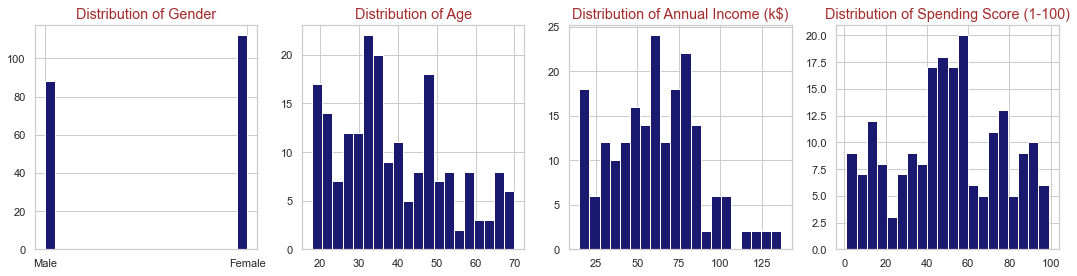

In [22]:
plot_histograms(cust_df, cust_df.columns[1:5], 1, 4)

#### 2.4.3.2. Draw Multivariate plots to better understand the relationship between attributes

#### Plot distributions of *`Gender in Age, Annual Income & Spending Score`*:

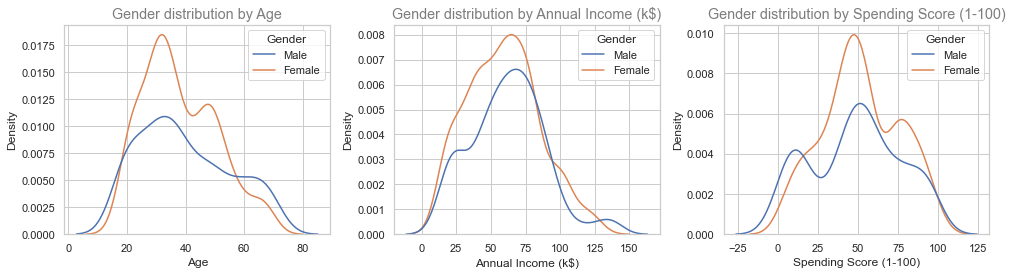

In [23]:
features = cust_df.columns[2:5]
title    = 'Gender distribution'
rows     = 1
cols     = len(features)

plot_genderdistribution(cust_df, cust_df.columns[2:5], title, rows, cols)

#### Plot distributions of *`Age in Annual Income & Spending Score`*:

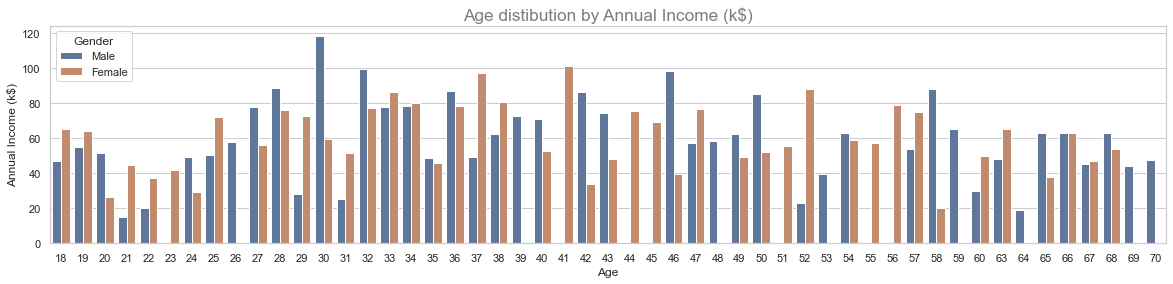

In [24]:
x   = cust_df.columns[2]
y   = cust_df.columns[3]
hue = cust_df.columns[1]

plot_barchart(cust_df, x, y, hue)

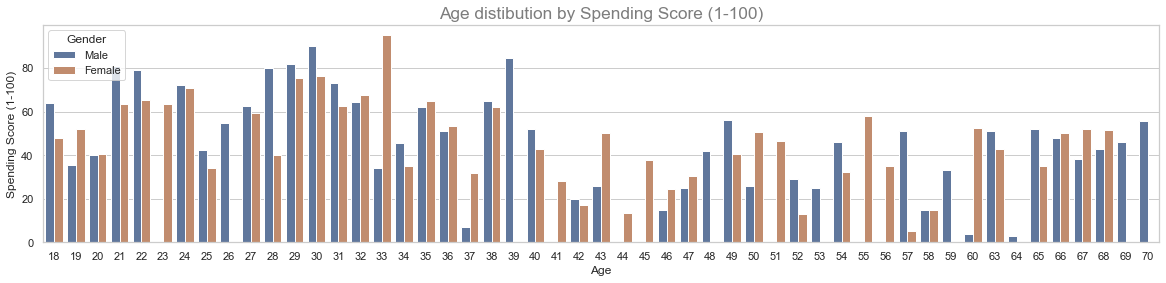

In [25]:
x   = cust_df.columns[2]
y   = cust_df.columns[4]
hue = cust_df.columns[1]

plot_barchart(cust_df, x, y, hue)

#### Correlation Map:

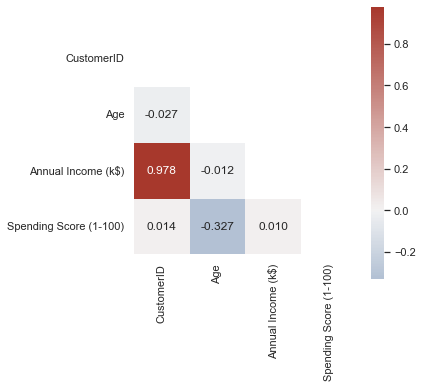

In [26]:
plot_correlationmap(cust_df)

#### Plot Scattercharts for *`Age vs Spending Score`* & *`Annual Income vs Spending Score`*:

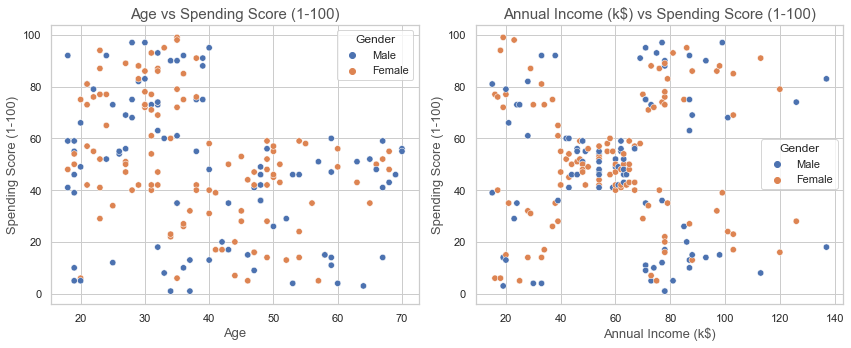

In [27]:
x_features = cust_df.columns[2:4]
y_feature  = cust_df.columns[4]
rows       = 1
cols       = 2

plot_scatterchart(cust_df, x_features, y_feature, rows, cols)

**Inferences from the above charts**: 
```
* Comparitively, Female "spend more" than Male
* The middle age group (25-58) is the "High Income group"
* The young age group (18-40) is the "High Spending group"
```

# 3. Research

Clustering is an unsupervised learning problem that does not deal with labeled data as in supervised learning. Since the datasets contain unlabeled data, they will not be split into train and test datasets for model training and validation purposes. In nutshell, the following phases are not applicable for clustering problems as these are applicable only for supervised learning problems.
```
* Model Training   (deals with train datasets)
* Model Evaluation (deals with train datasets)
* Model Validation (deals with test datasets)
```

`Model Deployment`: The developed model is not a one-time development as every single dataset may change the outputs completely, so the model is not deployed into the production environment to run against new datasets every time.

Hence, the following are the phases involved in the Clustering ML problem.
```
1) Business Understanding
2) Data Understanding
3) Research
4) Data Preprocessing
5) Model Development
6) Model Refinement
7) Final Model Selection
8) Conclusion
```

## 3.1. List of selected algorithms to build models

The following algorithm has been selected for the project. The model will be developed with default parameters. Then, the model will be individually tuned to minimize error. The final model will be selected based on their evaluation metrics.

#### Clustering algorithm:
```
 1) KMeans Clustering (KMeans)          KMeans()            - Clustering
```

## 3.2. List of model evaluation metrics

#### Clustering Evaluation metrics:
The following metrics have been selected as the `evaluation metrics` to determine the number of clusters during developing and refining the models.
```
1) KMeans score             # for Elbow method
2) Silhouette score         # 1 (best), -1 (poor), 0 (overlapping clusters)
3) Davies Bouldin score    # Lowest (best), 0 (min score)
```

# 4. Data Preprocessing

## 4.1. Data Cleaning

*Data Cleaning is not done as the dataset is tiny and clean without any missing values. However, CustomerID is not required for clustering algorithm.*

In [28]:
df = cust_df.drop(columns='CustomerID')

## 4.2. Feature Selection

*Feature Selection is not done because the dataset has only 5 features and all are required for further processing.*

## 4.3. Feature Engineering

*Feature Engineering is not required.*

## 4.4. Dimensionality Reduction

*Dimensionality Reduction is not done because the dataset has only 5 features and all are required for further processing.*

## 4.5. Split datasets for train-test

*This is an unsupervised learning problem, so train-test dataset split is not required.*

## 4.6. Data Transforms

### 4.6.1. Transforming `Numerical type`

#### Standardization:

In [29]:
df_std = df.copy()

for f in df_std.columns[1:4]:
    df_std[f] = standardize(cust_df, f)

### 4.6.2. Transforming `Categorical type`

#### One-Hot encode (Nominal):

In [30]:
df_transformed  = pd.get_dummies(df_std, columns=['Gender'], drop_first=True)

# 5. Model Development

#### Check the differences between the `Scaled` and `Unscaled` datasets:

 CORRELATIONS BETWEEN TWO FEATURES ON DIFFERENT SCALES:
 


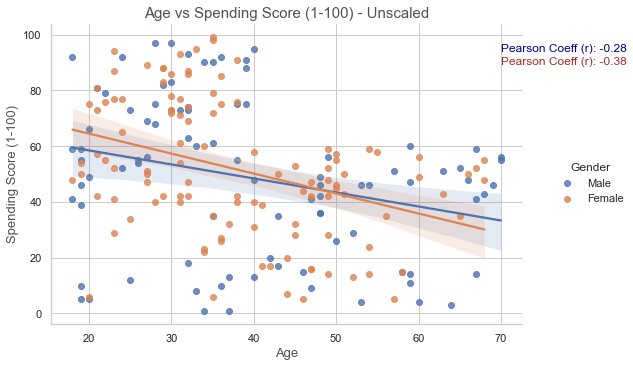

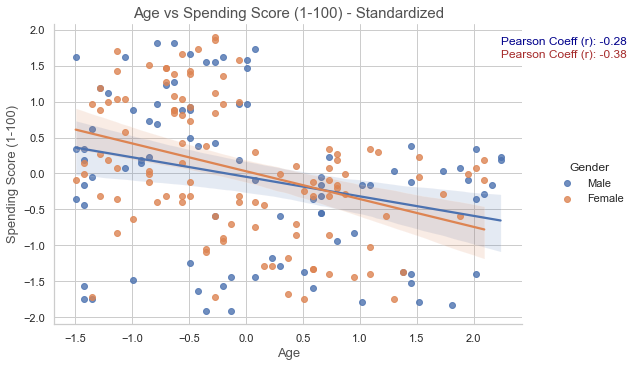

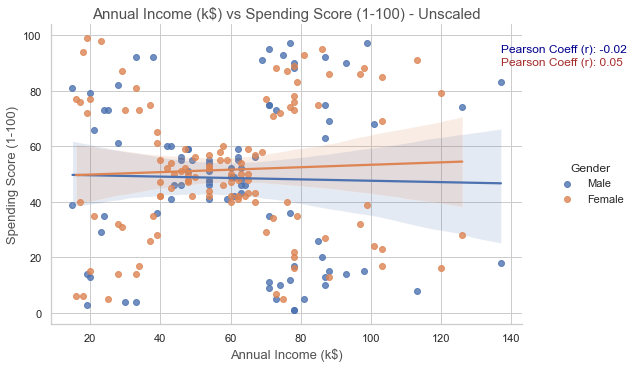

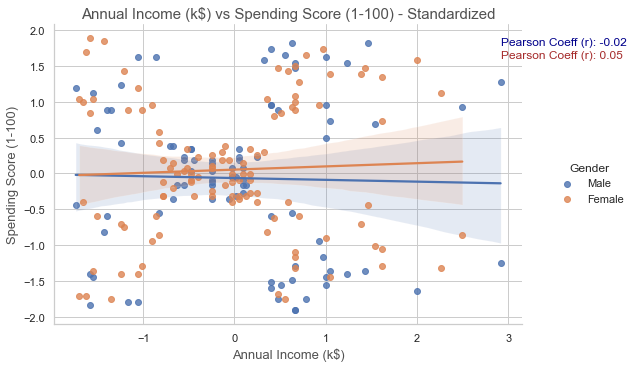

In [31]:
print('\033[1m', 'CORRELATIONS BETWEEN TWO FEATURES ON DIFFERENT SCALES:\n', '\033[0m')
plot_regression(cust_df, cust_df.columns[2], cust_df.columns[4], 'Unscaled')
plot_regression(df_std, df_std.columns[1], df_std.columns[3], 'Standardized')
plot_regression(cust_df, cust_df.columns[3], cust_df.columns[4], 'Unscaled')
plot_regression(df_std, df_std.columns[2], df_std.columns[3], 'Standardized')

*Its observed that there is no difference in Pearson Coefficients between the `Scaled` and `Unscaled` datasets.*

```
Strength of Association   |   Positive   |    Negative    |
--------------------------|--------------|----------------|
Small                     |  0.1 to 0.3  |  -0.1 to -0.3  |
Medium                    |  0.3 to 0.5  |  -0.3 to -0.5  |
Large                     |  0.5 to 1.0  |  -0.5 to -1.0  |
```

#### Build a KMeans clustering model with default values:

In [32]:
score_inr_dev = []
score_sil_dev = []
score_dbs_dev = []

model = KMeans(random_state=0).fit(df_transformed)
pred  = model.predict(df_transformed)
score_inr_dev = -model.score(df_transformed)
score_sil_dev = silhouette_score(df_transformed, pred)        # 1 (best), -1 (poor), 0 (overlapping clusters)
score_dbs_dev = davies_bouldin_score(df_transformed, pred)    # Lowest (best), 0 (min score)

print('INERTIA       - Number of Clusters: {}, Score: {}'.format(model.n_clusters, round(score_inr_dev, 3)))
print('SILHOUETTE    - Number of Clusters: {}, Score: {}'.format(model.n_clusters, round(score_sil_dev, 3)))
print('DAVIS-BOULDIN - Number of Clusters: {}, Score: {}'.format(model.n_clusters, round(score_dbs_dev, 3)))

INERTIA       - Number of Clusters: 8, Score: 151.54
SILHOUETTE    - Number of Clusters: 8, Score: 0.328
DAVIS-BOULDIN - Number of Clusters: 8, Score: 1.128


# 6. Model Refinement

#### Generate Performance Metrics (inter-cluster distance score) for different clusters:

In [33]:
scores_inr_rfnd = []
scores_sil_rfnd = []
scores_dbs_rfnd = []

for i in range(2, 12):
    model = KMeans(n_clusters=i, random_state=0).fit(df_transformed)
    pred  = model.predict(df_transformed)
    scores_inr_rfnd.append(-model.score(df_transformed))                  # Inertia / scores to plot elbow
    scores_sil_rfnd.append(silhouette_score(df_transformed, pred))        # 1 (best), -1 (poor), 0 (overlapping clusters)
    scores_dbs_rfnd.append(davies_bouldin_score(df_transformed, pred))    # Lowest (best), 0 (min score)

# 7. Final Model Selection

#### Determine the number of clusters using the *`Elbow method`*:

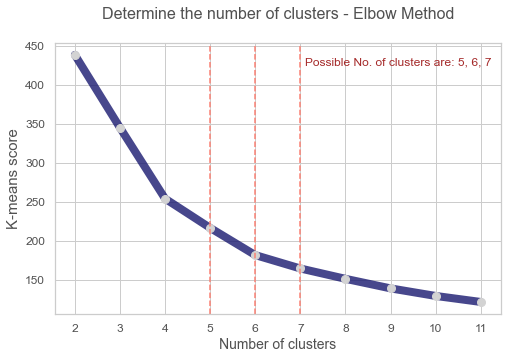

In [34]:
plt.figure(figsize=(8, 5))
plt.title("Determine the number of clusters - Elbow Method\n", fontsize=16, alpha=0.8)
plt.plot(range(2, 12), scores_inr_rfnd, '-', color='midnightblue', linewidth=8, alpha = 0.8)
plt.plot(range(2, 12), scores_inr_rfnd, 'o', color='lightgrey', markersize=8)    
plt.xlabel("Number of clusters", fontsize=14, alpha=0.8)
plt.ylabel("K-means score", fontsize=15, alpha=0.8)
plt.axvline(5, ls='--', c='salmon')
plt.axvline(6, ls='--', c='salmon')
plt.axvline(7, ls='--', c='salmon')
plt.text(7.1, 425, 'Possible No. of clusters are: 5, 6, 7', c='brown')
plt.xticks([i for i in range(2, 12)], fontsize=12, alpha=0.8)
plt.yticks(fontsize=12, alpha=0.8)
plt.show()

#### Determine the number of clusters using the *`Silhouette Coefficient Score`*:

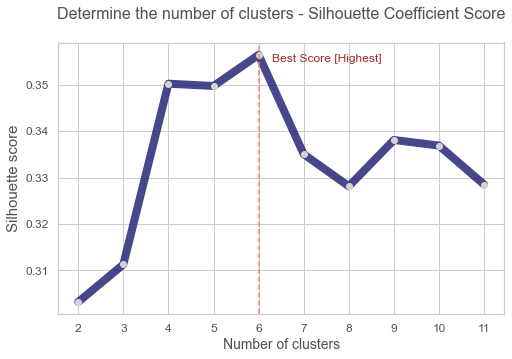

In [35]:
plt.figure(figsize=(8, 5))
plt.title("Determine the number of clusters - Silhouette Coefficient Score\n", fontsize=16, alpha=0.8)
plt.plot(range(2, 12), scores_sil_rfnd, '-', color='midnightblue', linewidth=8, alpha = 0.8)
plt.plot(range(2, 12), scores_sil_rfnd, 'o', color='lightgrey', linewidth=20,)    
plt.xlabel("Number of clusters", fontsize=14, alpha=0.8)
plt.ylabel("Silhouette score", fontsize=15, alpha=0.8)
plt.axvline(6, ls='--', c='salmon')
plt.text(6.3, 0.355, 'Best Score [Highest]', c='brown')
plt.xticks([i for i in range(2, 12)], fontsize=12, alpha=0.8)
plt.yticks(fontsize=12, alpha=0.8)
plt.show()

#### Determine the number of clusters using the *`Davies Bouldin Score`*:

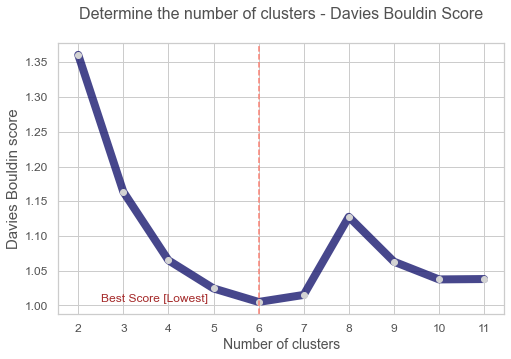

In [36]:
plt.figure(figsize=(8, 5))
plt.title("Determine the number of clusters - Davies Bouldin Score\n", fontsize=16, alpha=0.8)
#plt.scatter(x=[i for i in range(2,12)], y=scores_dbs, s=150, edgecolor='k', alpha=0.8)
plt.plot(range(2, 12), scores_dbs_rfnd, '-', color='midnightblue', linewidth=8, alpha = 0.8)
plt.plot(range(2, 12), scores_dbs_rfnd, 'o', color='lightgrey', linewidth=20,)    
plt.xlabel("Number of clusters", fontsize=14, alpha=0.8)
plt.ylabel("Davies Bouldin score", fontsize=15, alpha=0.8)
plt.axvline(6, ls='--', c='salmon')
plt.text(2.5, 1.005, 'Best Score [Lowest]', c='brown')
plt.xticks([i for i in range(2, 12)], fontsize=12, alpha=0.8)
plt.yticks(fontsize=12, alpha=0.8)
plt.show()

#### Plot and compare the refined scores and select the best cluster number:

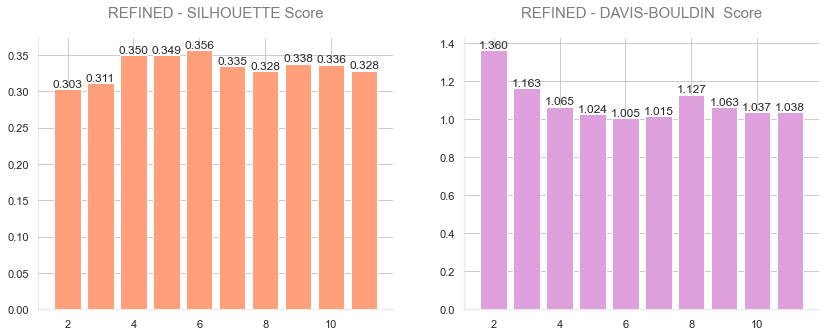

The Highest SILHOUETTE   score is: 0.356, and the # of Clusters is: 6
The Lowest DAVIS-BOULDIN score is: 1.005, and the # of Clusters is: 6


In [37]:
# Plot and compare the scores
scores_list = [scores_sil_rfnd, scores_dbs_rfnd]
score_names = ['REFINED - SILHOUETTE Score', 'REFINED - DAVIS-BOULDIN  Score']
colors      = ['lightsalmon', 'plum']
clusters    = list(range(2,12))

plot_performance_metrics(scores_list, score_names, colors, clusters)

clnumsil = np.argmax(scores_sil_rfnd)                     # Highest is the best score
clnumdbs = np.argmin(scores_dbs_rfnd)                     # Lowest is the best score

print('The Highest SILHOUETTE   score is: {}, and the # of Clusters is: {}'.format(round(max(scores_sil_rfnd), 3), clusters[clnumsil]))
print('The Lowest DAVIS-BOULDIN score is: {}, and the # of Clusters is: {}'.format(round(min(scores_dbs_rfnd), 3), clusters[clnumdbs]))

#### Capture the *`cluster labels`* and *`cluster centers`*:

In [38]:
nclusters = 6

model6 = KMeans(n_clusters=nclusters, random_state=3).fit(df_transformed)

model6_df = df_transformed.copy()
model6_df.loc[:,'Cluster'] = model6.labels_      # append labels to points

cc = model6.cluster_centers_                     # Capute the cluster centers

# 8. Conclusion

*Based on all the evaluation metrics, the best scores for the number of clusters is 6 (cluster numbers ranging from 0 to 5).*

#### Plot *`2D view`* of clusters with cluster-centers:

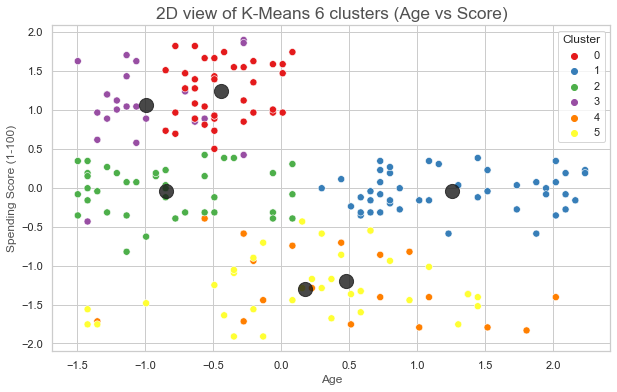

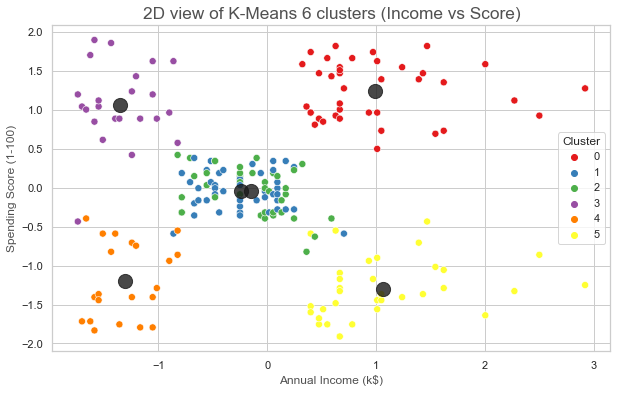

In [39]:
title = '2D view of K-Means 6 clusters (Age vs Score)'
x, y  = 'Age', 'Spending Score (1-100)'
plot_clusters2d(model6_df, x, y, 'Cluster', cc, title)

title = '2D view of K-Means 6 clusters (Income vs Score)'
x, y  = 'Annual Income (k$)', 'Spending Score (1-100)'
plot_clusters2d(model6_df, x, y, 'Cluster', cc, title)

#### Plot *`3D view`* of clusters with cluster-centers:

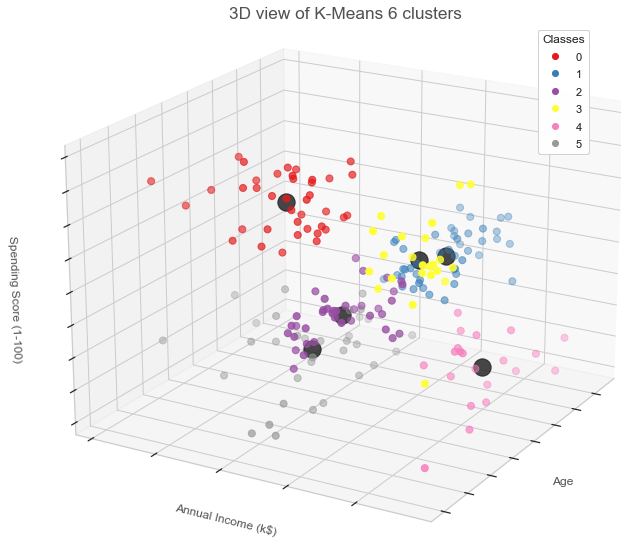

In [40]:
x, y, z = 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'
title   = '3D view of K-Means 6 clusters'
plot_clusters3d(model6_df, x, y, z, 'Cluster', cc, title)

#### The clusters generated by the KMeans algorithm are:
```
Cluster 0 - Customers with HIGH INCOME   has HIGH SPENDING SCORE   (Mixed Age)   - Not a target
Cluster 1 - Customers with MEDIUM INCOME has MEDIUM SPENDING SCORE (Old Age)     - Not a target
Cluster 2 - Customers with MEDIUM INCOME has MEDIUM SPENDING SCORE (Young Age)   - Not a target
Cluster 3 - Customers with LOW INCOME    has HIGH SPENDING SCORE   (mixed Age)   - Not a target
Cluster 4 - Customers with LOW INCOME    has LOW SPENDING SCORE    (mixed Age)   - Not a target
Cluster 5 - Customers with HIGH INCOME   has LOW SPENDING SCORE    (mixed Age)   - TARGET GROUP
```

#### Append the cluster numbers with customer dataset:

In [41]:
cust_cluster_df = pd.concat([cust_df, model6_df['Cluster']], axis=1)

#### Extract the customer details for cluster 6 (cluster number 5):

In [42]:
target_customers = cust_cluster_df[cust_cluster_df['Cluster'] == (nclusters-1)]

### The list of customers to be given to the marketing team to come up with marketing strategies are:

In [45]:
target_customers.to_csv(path_or_buf='target_customers_list-Out.csv', index=False)

In [46]:
target_customers

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
126,127,Male,43,71,35,5
128,129,Male,59,71,11,5
130,131,Male,47,71,9,5
134,135,Male,20,73,5,5
136,137,Female,44,73,7,5
138,139,Male,19,74,10,5
140,141,Female,57,75,5,5
144,145,Male,25,77,12,5
146,147,Male,48,77,36,5
148,149,Female,34,78,22,5
